# Lab2 (5IR - 2024): Fall Detection - Supervised learning

**Group name (2 people !):**

**Names:**

**First names:**

The objectives of this lab are
- Development of a classification model based on artificial neural networks for the fall detection dataset CAUCA,
- Use TensorFlow to determine a performant CNN architecture,
- Study of the architecture of a neural network and the sensitivity of its parameters,
- Use TensorFlow Lite to compress the CNN,
- (Optional) Implementation of Transfer Learning using an efficient architecture (e.g. MobileNetV2).

In [1]:
# # To run on the machines at INSA, this should be enough using anaconda:
# conda create -n 5ISS_ML2 python=3.9 -y
# conda activate 5ISS_ML2
# pip install ipykernel
# pip install tensorflow==2.15.1
# pip install tensorflow_model_optimization==0.7.5
# pip install matplotlib scikit-learn seaborn opencv-python
# python -m ipykernel install --user --name=5ISS_ML2 --display-name "Python (5ISS_ML2)"

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from keras.models import Sequential, save_model, clone_model, load_model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization
from keras.utils import to_categorical
from keras.saving import load_model

# TensorFlow Optimization
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity.keras import prune_low_magnitude, PolynomialDecay, UpdatePruningStep, ConstantSparsity

import numpy as np
import matplotlib.pyplot as plt
import random
import numpy as np
import tempfile
import os
import zipfile
import math
import pickle
from sklearn.metrics import confusion_matrix
import cv2
from sklearn.model_selection import train_test_split

# 1. Classification of the CAUCA dataset using Convolutional Neural Netowrks (CNN)

TensorFlow is an open-source machine learning library developed by Google, primarily used for deep learning applications. It provides a comprehensive, flexible ecosystem of tools, libraries, and community resources that enables researchers to develop and deploy machine learning powered applications easily. We use the Python version of the library which can be installed in Python with:
*pip install tensorflow*

We will use the library **tensorflow.keras** to develop ANN of type Convolutional Neural Netowrks (CNN). We use the generic class **Sequential** combined with layers of types:
- **Conv2D**,
- **MaxPooling2D**,
- **BatchNormalization**,
- **Dropout**,
- **Flatten**,
- **Dense**.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*uAeANQIOQPqWZnnuH-VEyw.jpeg" alt="CNN example" />

The documentation for the Tensorflow layers is available at https://www.tensorflow.org/api_docs/python/tf/keras/layers.
Since an example is better than 1000 words, below is a fully working example code for a toy classification problem.

## 1.1 Hand-drawn shapes (HDS) dataset

Some datasets are available on the internet (search Google, Kaggle, and scientific articles). Here, we focus on a small example dataset extracted from the repository: https://github.com/frobertpixto/hand-drawn-shapes-dataset/tree/main. This dataset contains 70x70px images (in .png format) in grayscale of hand-drawn shapes. The images can be of 4 classes: ellipse, triangle, rectangle, others. There are around 50 000 images available. Processing codes are available on github to preprocess the pictures, and build a CNN model for classification.

<img src="https://raw.githubusercontent.com/frobertpixto/hand-drawn-shapes-dataset/main/readme_images/train_images.png" alt="HDS example" />

We have modified the processing code from the repository in order to reduce the dataset for our purpose:
- The images are resized to 14x14px,
- We only keep the classes ellipse, triangle, and rectangle,
- We keep 4 500 images.

The dataset is stored in a pickle file which allows to drop Python data structures to a binary file. The structure is a dictionnary with the data X at key "train_data", and the labes y at key "train_labels":
- Storing:
*save_to_pickle(*
    *"train.pickle",*
    *{*
        *'train_data': train_data,*
        *'train_labels': train_labels*
    *}*
*)*
- Loading
*with open("train.pickle", 'rb') as file:*
    *train_dict = pickle.load(file)*

- Load data
- N.B.: In the obtained labels y, class 1="ellipse", class 2="rectangle", class 3="triangle"

In [4]:
with open("hds_data.pickle", 'rb') as file:
    train_dict = pickle.load(file)
X = train_dict['train_data']
y = train_dict['train_labels'] - 1

Image:  4228


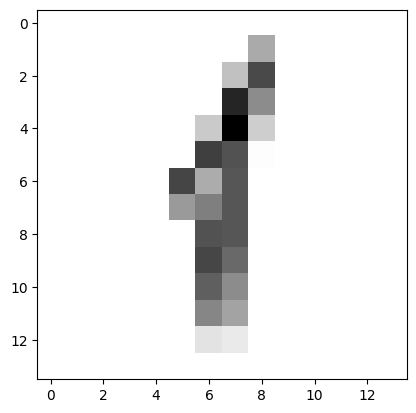

In [5]:
ind = random.randint(0, len(X))
print("Image: ",ind)
plt.imshow(X[ind],cmap=plt.cm.gray_r,interpolation="nearest")
plt.show()

- **Split into train and test datasets**

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)

# Reshape and normalize the images
xtrain = xtrain.reshape((xtrain.shape[0], 14, 14, 1)).astype('float32')
xtest = xtest.reshape((xtest.shape[0], 14, 14, 1)).astype('float32')

# Convert labels to categorical (one-hot encoding)
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)

- **Create the model**

In [7]:
# Building the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(14, 14, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 12, 12, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 12, 12, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 6, 6, 32)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 32)                36896     
                                                                 
 dense_1 (Dense)             (None, 3)                 9

- **Compile and train the model**

In [8]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(xtrain, ytrain, validation_data=(xtest, ytest), epochs=10, batch_size=128)

Epoch 1/10
29/29 [==============================] - 1s 12ms/step - loss: 0.8009 - accuracy: 0.6608 - val_loss: 1.0378 - val_accuracy: 0.6167
Epoch 2/10
29/29 [==============================] - 0s 9ms/step - loss: 0.5008 - accuracy: 0.8061 - val_loss: 1.0018 - val_accuracy: 0.5722
Epoch 3/10
29/29 [==============================] - 0s 9ms/step - loss: 0.4014 - accuracy: 0.8453 - val_loss: 0.9635 - val_accuracy: 0.7633
Epoch 4/10
29/29 [==============================] - 0s 9ms/step - loss: 0.3258 - accuracy: 0.8767 - val_loss: 0.9222 - val_accuracy: 0.7778
Epoch 5/10
29/29 [==============================] - 0s 9ms/step - loss: 0.2853 - accuracy: 0.8919 - val_loss: 0.8808 - val_accuracy: 0.7322
Epoch 6/10
29/29 [==============================] - 0s 9ms/step - loss: 0.2442 - accuracy: 0.9069 - val_loss: 0.8208 - val_accuracy: 0.8311
Epoch 7/10
29/29 [==============================] - 0s 9ms/step - loss: 0.2096 - accuracy: 0.9261 - val_loss: 0.7874 - val_accuracy: 0.7256
Epoch 8/10
29/29 [=

- **TODO: Evaluate the model** (this will help you later):
    - display a random image in the test set with its true and predicted labels,
    - display the accuracy of the CNN on the train and test sets,
    - compute and display the confusion matrix of the model,
    - display the evolution of the accuracy over the training iterations of the CNN.

Image:  1760


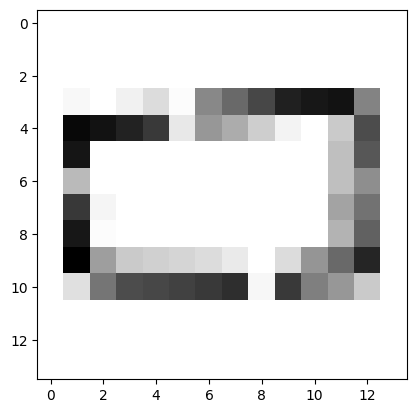

1
0.9594444632530212
0.8366666436195374
29/29 [==============================] - 0s 1ms/step


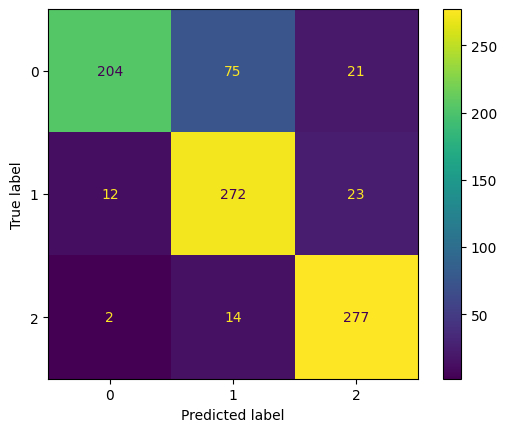

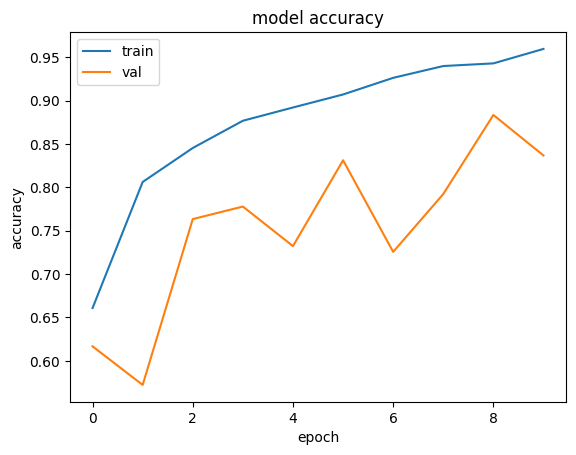

In [9]:
# TODO
from sklearn.metrics import ConfusionMatrixDisplay

# Display a random image in the test set with its true and predicted labels
ind = random.randint(0, len(X))
print("Image: ",ind)
plt.imshow(X[ind],cmap=plt.cm.gray_r,interpolation="nearest")
plt.show()
print(y[ind])

# Display the accuracy of the CNN on the train and test sets,
print(history.history['accuracy'][9])
print(history.history['val_accuracy'][9])
# Compute and display the confusion matrix of the model

y_pred = model.predict(xtest)
#y_pred = to_categorical(y_pred)

predictest = np.argmax(y_pred, axis=1)
ytest2 = np.argmax(ytest, axis=1)

ConfusionMatrixDisplay.from_predictions(ytest2, predictest)
plt.show()

# Display the evolution of the accuracy over the training iterations of the CNN.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

- **TODO: Questions:** (this will help you later)

    - look at the documentation of Tensorflow (or other) and explain briefly what is the a *Dropout* layer.
      
 Le Dropout est une technique permettant de réduire l’overfitting lors de l’entraînement du modèle. Il désactive temporairement certains neurones dans le réseau, ainsi que toutes ses connexions entrantes et sortantes

    - what does the *to_categorical* function do and why do we modify the labels (ground truth) with it ?

Convertit un vecteur de classe (entiers) en une matrice de classe binaire. 

    - what is contained in the prediction for any example ?

In [10]:
model.save("best_CNN.keras")
model2 = load_model("best_CNN.keras")

## 1.2 Classification of the CAUCA dataset

Goal: adapt the example of the HDS dataset classification above to build a performant classifier for the CAUCA dataset. Be creative and do not hesitate to explore CNN architectures !

For example, you can implement the CNN architecture shown above in the picture of the part 2 on CNN.

### CAUCA fall detection dataset

The CAUCA dataset is avalaible at:
https://data.mendeley.com/datasets/7w7fccy7ky/4
The dataset of falls contains data from 10 different activities: Fall backwards, fall forward, fall left, fall right, fall sitting, hop, kneel, pick up object, sit down, walk.
The 20000 labelled images were obtained from videos taken in conditions of an uncontrolled home environment (occlusions, lights, clothes, etc.).
Each of the 10 subjects had to follow a specific protocol, containing the 10 different "activities".

<img src="CAUCA_ex.jpeg" alt="HDS example" />

We have preprocessed the images for a better classification:
- A YOLO model was used to segment the person in each picture, resulting in square images of size ranging between 200 and 350,
- The images were resized to be 96 × 96 or 224 x 224,
- Labels are merged to get : fall vs. non-fall activity.

The datasets are stored in pickle file which allows to drop Python data structures to a binary file. The structure is a dictionnary with the data X at key "train_data", and the labes y at key "train_labels":
- Storing:
*save_to_pickle(*
    *"train.pickle",*
    *{*
        *'data': train_data,*
        *'labels': train_labels,*
        *'width': width,*
        *'height': height,*
        *'channels': channels*
    *}*
*)*
- Loading
*with open("train.pickle", 'rb') as file:*
    *train_dict = pickle.load(file)*

Four sets are available
- Training set (data_train_w_h_c.pickle): images of subjects 1-8,
- Final est set (data_test_w_h_c.pickle): images of subjects 9 and 10.

- **TODO: Explore the training data of images 96 x 96 px**
    - load the data from the corresponding pickle file
    - display an image of the train set for each label (0: non-fall, 1: fall) and display the label
    - split the data into train and validation set
    - transform the labels with *to_categorical*

Image avec label 0


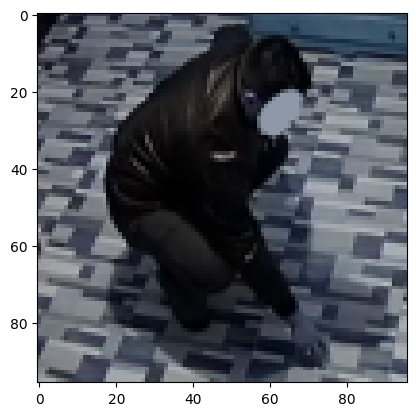

Image avec label 1


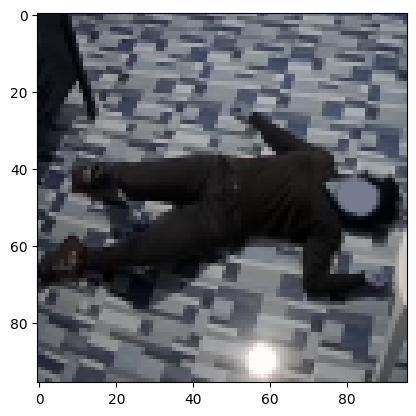

In [11]:
# TODO
with open("data_train_96_96_3.pickle", 'rb') as file:
    train_dict = pickle.load(file)

train_data = train_dict['data']
train_label = train_dict['labels'] 

r1 = 0
r0 = 0
for i in range(0, len(y)):
    if(y[i]==0):
        r1 = i
    else:
        r0 = i

print("Image avec label", train_label[r1])
plt.imshow(train_data[r1],cmap=plt.cm.gray_r,interpolation="nearest")
plt.show()
print("Image avec label", train_label[r0])
plt.imshow(train_data[r0],cmap=plt.cm.gray_r,interpolation="nearest")
plt.show()

xtrain, xtest, ytrain, ytest = train_test_split(train_data, train_label, train_size=0.8)

# Convert labels to categorical (one-hot encoding)
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)

- **TODO: Questions:**
    - which activation function is generally used for CNN ?
 
ReLU function

    - what purpose serve the BatchNormalisation layer ?
    
Son utilité principale est d’améliorer la stabilité et la vitesse d'entraînement du modèle. Dans un CNN, les valeurs qui sortent d'une couche peuvednt être : très grandes, très petites la batch normalization permet de normalisé les valeur en sortie de la convolution. En les centratn autour de 0. On a donc du sortie plus sable pour la fonction d'activation.

- **TODO: Build a CNN classifier for fall detection**
    - Construct as a *Sequential* model the CNN which structure is given as an image in introduction with n1=n2=32, n3=64.
    - Show the number of parameters, and compile the model
 
<img src="https://miro.medium.com/v2/resize:fit:1400/1*uAeANQIOQPqWZnnuH-VEyw.jpeg" alt="CNN example" />

In [12]:
# TODO
# Building the CNN model

model = Sequential([
        Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(96, 96, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=(5, 5), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])
#Conv2D jusqu'à MaxPooling2D = une couche (n1 et n2) et Flatten Dense = n3 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        2432      
                                                                 
 batch_normalization_1 (Bat  (None, 92, 92, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 46, 46, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 42, 42, 32)        25632     
                                                                 
 batch_normalization_2 (Bat  (None, 42, 42, 32)        128       
 chNormalization)                                                
                                                      

- **Training the model**
    - Actual training = fit with 5 epochs (can take some time depending on your architecture),
    - Do not forget to pass the argument *validation_data*,
    - Store the outputs (*history*) !

In [13]:
# TODO
# Compile the model
import numpy as np
print(np.unique(np.argmax(ytrain, axis=1)))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(xtrain, ytrain, validation_data=(xtest, ytest), epochs=10, batch_size=128)

[0 1]
Epoch 1/10
40/40 [==============================] - 37s 922ms/step - loss: 0.8338 - accuracy: 0.8831 - val_loss: 30.7782 - val_accuracy: 0.3921
Epoch 2/10
40/40 [==============================] - 37s 938ms/step - loss: 0.0377 - accuracy: 0.9883 - val_loss: 6.4802 - val_accuracy: 0.4333
Epoch 3/10
40/40 [==============================] - 36s 894ms/step - loss: 0.0175 - accuracy: 0.9942 - val_loss: 2.2957 - val_accuracy: 0.6373
Epoch 4/10
40/40 [==============================] - 36s 902ms/step - loss: 0.0096 - accuracy: 0.9966 - val_loss: 0.4265 - val_accuracy: 0.8738
Epoch 5/10
40/40 [==============================] - 36s 906ms/step - loss: 0.0074 - accuracy: 0.9982 - val_loss: 0.0844 - val_accuracy: 0.9611
Epoch 6/10
40/40 [==============================] - 38s 945ms/step - loss: 0.0077 - accuracy: 0.9982 - val_loss: 0.0311 - val_accuracy: 0.9921
Epoch 7/10
40/40 [==============================] - 36s 894ms/step - loss: 0.0062 - accuracy: 0.9986 - val_loss: 0.0060 - val_accuracy:

- **TODO: Evaluate the model:**
    - display the evolution of the accuracy over the training iterations of the CNN
    - display the accuracy of the model on the train and validation sets,
    - compute and display the confusion matrix of the model.

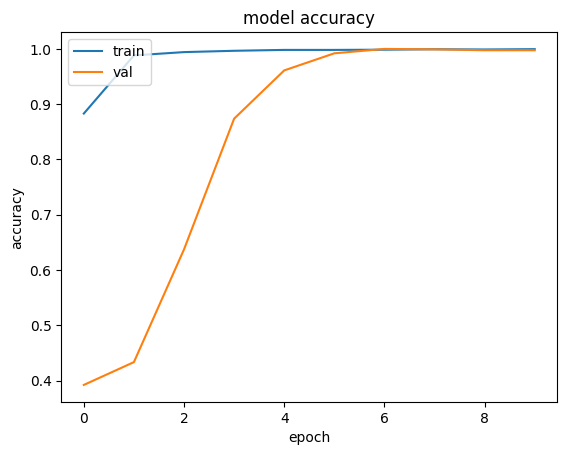

test :  0.9996030330657959
val : 0.9976190328598022


In [18]:
# TODO
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

print("test : ", history.history['accuracy'][9])
print("val :", history.history['val_accuracy'][9])

- **TODO: Final evaluation of the model:**
    - load the data (pickle file) from the test set with images 96 x 96 px
    - transform the labels with *to_categorical*
    - evaluate the performance of the model you selected on this final test set
    - are your satisfied ?
    - do you observe underfitting/overfitting ?

Après avoir fait plusieurs test pour 5 epochs nous avons essayé avec un plus grand nombre d'epoch pour observé l'underfitting / l'overfitting sur de plus longue période.

Le modèle montre d’excellentes performances globales avec une accuracy sur l'entraînement et la validation > 99 %. Les performances sur le jeu de validation s'améliorent rapidement et deviennent très élevéas à partir de l'époch 5 avec un pique à 1 ?! pour le jeu de validation à l'époch 7. Le modèle généralise bien sur les données de validation.

Les résultats sont très satisfaisants ! L’accuracy de validation est très proche de celle de l’entraînement, la loss de validation est faible et stable.

On observe pas d'overfitting (excepté sur les toutes premières epochs) et pas d'underfitting.

Les résultats du modèle sont exceptionnel ! 

62/62 [==============================] - 2s 34ms/step
0.9703020993343574


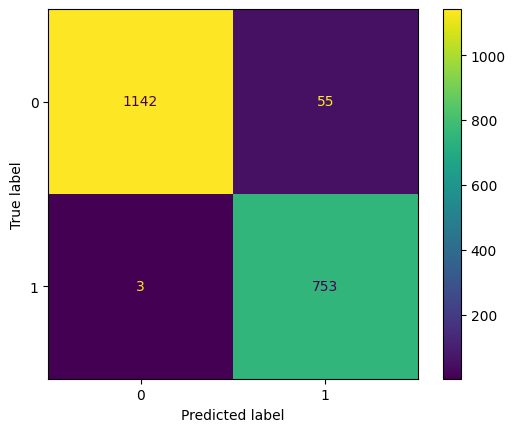

In [17]:
# TODO
from sklearn.metrics import accuracy_score
with open("data_test_96_96_3.pickle", 'rb') as file:
    train_dict = pickle.load(file)

valid_data = train_dict['data']
valid_label = train_dict['labels']

#valid_label = to_categorical(valid_label)

predict = model.predict(valid_data)

predict = np.argmax(predict, axis=1)


accuracy = accuracy_score(valid_label, predict)

print(accuracy)

ConfusionMatrixDisplay.from_predictions(valid_label, predict)

#Comparer prediction avec valid label

On observe un nombre plus élevé d’erreurs associées au label 1 (personne tombée) qu’au label 0 (personne debout), ce qui est plutôt une bonne nouvelle. En effet, ces erreurs correspondent principalement à des faux positifs, c’est-à-dire des situations où le système détecte une chute alors qu’il n’y en a pas réellement eu. Dans un tel domaine d’application (détection de chute), les faux positifs sont moins problèmatique que les faux négatifs. Un faux négatif, qui consisterait à ne pas détecter une chute réelle, pourrait avoir des conséquences graves. Même si cela dépend toujours de l'application cible.

- save your model to the file "best_CNN.keras"

In [19]:
final_model=model
final_model.save("best_CNN.keras")

In [20]:
model = tf.keras.models.load_model("best_CNN.keras")

# 2. Compression of the CNN with a combination of pruning and quantization

TensorFlow and TensorFlow Lite include compression mechanisms to decrease the load of a CNN in terms of memory and computation.

We will use:
- the library **tensorflow_model_optimization** for network pruning without and with fine-tuning.
- the library **tf.lite.TFLiteConverter** to convert our model with TensorFlow Lite, with an application of quantization.

Search the web for the documentation, it can be a little hard for these aspects so **don't give up**.

## Given funtions
We give you a small set of functions that will help you during the following of the lab.
These functions mainly serve
- to load models, write them to files, and estimate their size (see the doc of each function).
- to define specific extensions of the *tensorflow_optimization* package

In [21]:
def setup_model(model_file):
    """Setup a model from a file where is was written using e.g. model.save(filename)

    Parameters
    ----------
    model_file : str
        The file containing the model

    Returns
    -------
    tf_model
        the loaded model
    """
    
    model = load_model(model_file)
    return model

def save_pruned_model(model, model_file=None):
    """Save a pruned model after preprocessing it (strip pruneLowMagnitude layers)

    Parameters
    ----------
    model : tf_model
        The pruned model to save.
    model_file : str (Optional)
        The file where the model should be saved
        
    Returns
    -------
    tf_model
        The preprocessed model for export
    str
        The file where the model has been saved
    """
    model_for_export = tfmot.sparsity.keras.strip_pruning(model)
    
    if model_file is None:
        _, model_file = tempfile.mkstemp('.h5')
    tf.keras.models.save_model(model_for_export, model_file, include_optimizer=False)
    
    return model_for_export, model_file

def get_gzipped_model_size(model=None, keras_file=None, zipped_file=None):
    """Model size estimation:
    Write a model to a file, compress it using gzip and return the file size

    Parameters (at least one of the 3)
    ----------
    model : tf_model (optional)
        The model to estimate.
    keras_file : str (optional)
        The name of the file where the model is saved.
    zipped_file : str (optional)
        The name of the file containing the compressed model.

    Returns
    -------
    str
        The name of the file where the model is saved.
    str
        The name of the file containing the compressed model.
    int
        The size of the compressed model
    """    
    if model is not None:
        if keras_file is None:
            _, keras_file = tempfile.mkstemp('.h5')
        model.save(keras_file, include_optimizer=False)
        
        _, zipped_file = tempfile.mkstemp('.zip')
    
        with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
            f.write(keras_file)
    elif keras_file is not None:
        _, zipped_file = tempfile.mkstemp('.zip')
    
        with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
            f.write(keras_file)
    elif zipped_file is None:
        raise ValueError("You must provide at least model, keras_file, or zipped file")

    return keras_file, zipped_file, math.ceil(os.path.getsize(zipped_file))

def print_model_weights_sparsity(model):
    """Display the sparsity of each layer in a model

    Parameters
    ----------
    model : tf_model (optional)
        The model to analyze.
    """
    stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(model)
    for layer in stripped_pruned_model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )

def apply_constant_prune(model, sparsity, only_dense=1):
    """Calls tfmot.sparsity.keras.prune_low_magnitude with the possibility to only run on dense layers

    Parameters
    ----------
    model : tf_model
        The model to prune.
    sparsity : float
        The sparsity level to apply ConstantSparsity
    only_dense : int (default=1)
        Do we only apply pruning on the dense layers ?
        
    Returns
    -------
    tf_model
        the pruned model
    """
    def apply_pruning_to_dense(layer):
        if only_dense and isinstance(layer, tf.keras.layers.Dense):
            return tfmot.sparsity.keras.prune_low_magnitude(layer, ConstantSparsity(sparsity, 0))
        return layer
    model_for_pruning = clone_model(model, clone_function=apply_pruning_to_dense)
    return model_for_pruning

## 1.1 Network pruning

First, we will compress our CNN using a particular approach to network pruning using the function *ConstantSparsity* from the package **tfmot.sparsity.keras**: https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/sparsity/keras/ConstantSparsity.


<img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*nicFUkeUpWMW1w_hUVtZiw.png" alt="CNN example" />

This process in done in 3 steps:
- decide on the pruning function: pruning_schedule = tfmot.sparsity.keras.ConstantSparsity(...)
- build your pruning model: pruned_model = apply_constant_prune(model, sparsity, only_dense=1)
- compile and fit: the pruning model is applied during training !
=> the new model can be used for prediction, etc.


*Remark*: these steps could be repeated in an iterative process (see Lecture), but we will not do it here to decrease computation time.

- **TODO: Load the data** (yes, again)
    - training set (do not forget *to_categorical*) and split it as train/validation sets
    - final test set (no splitting)

In [22]:
# TODO
with open("data_train_96_96_3.pickle", 'rb') as file:
    train_dict = pickle.load(file)

train_data = train_dict['data']
train_label = train_dict['labels'] 
xtrain, xtest, ytrain, ytest = train_test_split(train_data, train_label, train_size=0.8)

# Convert labels to categorical (one-hot encoding)
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)


with open("data_test_96_96_3.pickle", 'rb') as file:
    train_dict = pickle.load(file)

xfinal = train_dict['data']
yfinal = train_dict['labels']

yfinal = to_categorical(yfinal)

- Load the model obtained before (done)

In [23]:
base_model = setup_model("best_CNN.keras")
baseline_model_loss, baseline_model_accuracy = base_model.evaluate(xfinal, yfinal, verbose=0)
print('Baseline test accuracy:', baseline_model_accuracy)
base_model.summary()

_,_, baseline_size = get_gzipped_model_size(model=base_model)
print("Baseline model size (gzipped):", baseline_size)

Baseline test accuracy: 0.9703021049499512
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        2432      
                                                                 
 batch_normalization_1 (Bat  (None, 92, 92, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 46, 46, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 42, 42, 32)        25632     
                                                                 
 batch_normalization_2 (Bat  (None, 42, 42, 32)        128       
 chNormalization)                                                
           

/home/tom/miniconda3/envs/5A_IA/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


- Pruning the model: the parameter *sparsity* for *ConstantSparsity* allows to choose the level of pruning applied.
    - The model should be trained (fit 2 epochs) in order to actually prune the network.
    - There is a callback parameter in the fit function which we provide below:
        - *UpdatePruningStep* is the option to apply pruning at each step of gradient descent,
        - *tfmot.sparsity.keras.PruningSummaries* allows to follow the evolution of the sparsity,
        - launch in a new terminal *tensorboard --logdir={log_dir}* where log_dir is the one generated below.

In [24]:
log_dir = tempfile.mkdtemp()
print(log_dir)
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=log_dir)
]

/tmp/tmpbm6y39lx


- **TODO: optimal pruning of the model**:
    - vary the level of sparsity and plot the evolution of
        - the accuracy for the pruned model (on train and validation),
        - the size of the original and new models as estimated by the provided function get_gzipped_model_size,
    - which choice of sparsity is the best ?
    - Save the corresponding model to the file "constant_pruning.h5" using save_pruned_model.

In [25]:
train_accs = []
val_accs = []
model_sizes = []

best_val_acc = 0
sparsity_levels = [0, 0.25, 0.5, 0.75, 0.9]
for sparsity in sparsity_levels:
    print(f"Sparsity = {sparsity}")

    #model
    base_model = setup_model("best_CNN.keras")

    #pruning
    pruned_model = apply_constant_prune(model=base_model, sparsity=sparsity, only_dense = 1)
    pruned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = pruned_model.fit(xtrain, ytrain, validation_data=(xtest, ytest), epochs=2, callbacks=callbacks)

#Acuracy
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]

    train_accs.append(train_acc)
    val_accs.append(val_acc)

    pruned_export, _ = save_pruned_model(pruned_model)
    _, _,pruned_size = get_gzipped_model_size(model=pruned_export)
    model_sizes.append(pruned_size)

    print("Train accuracy :", train_acc)
    print("Validation accuracy :", val_acc)
    print("Pruned size :", pruned_size)

    #Best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_sparsity = sparsity
        best_pruned_model = pruned_export

save_pruned_model(best_pruned_model, "constant_pruning.h5")

print("Best sparsity WWWWawwwwwww ! !! !! !:", best_sparsity)



Sparsity = 0
Epoch 1/2
158/158 [==============================] - 39s 236ms/step - loss: 0.0540 - accuracy: 0.9881 - val_loss: 1.4069 - val_accuracy: 0.8825
Epoch 2/2
158/158 [==============================] - 38s 238ms/step - loss: 0.0364 - accuracy: 0.9921 - val_loss: 4.3760 - val_accuracy: 0.7460


/tmp/ipykernel_11268/1507560165.py:39: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, model_file, include_optimizer=False)


Train accuracy : 0.9920603632926941
Validation accuracy : 0.7460317611694336
Pruned size : 3457148
Sparsity = 0.25
Epoch 1/2
158/158 [==============================] - 38s 236ms/step - loss: 0.0543 - accuracy: 0.9855 - val_loss: 1.4575 - val_accuracy: 0.8230
Epoch 2/2
158/158 [==============================] - 39s 249ms/step - loss: 0.0125 - accuracy: 0.9958 - val_loss: 0.0135 - val_accuracy: 0.9960
Train accuracy : 0.9958316683769226
Validation accuracy : 0.9960317611694336
Pruned size : 2874867
Sparsity = 0.5
Epoch 1/2
158/158 [==============================] - 39s 243ms/step - loss: 0.0801 - accuracy: 0.9843 - val_loss: 0.0141 - val_accuracy: 0.9944
Epoch 2/2
158/158 [==============================] - 37s 232ms/step - loss: 0.0071 - accuracy: 0.9982 - val_loss: 0.0042 - val_accuracy: 0.9992
Train accuracy : 0.9982135891914368
Validation accuracy : 0.9992063641548157
Pruned size : 2162625
Sparsity = 0.75
Epoch 1/2
158/158 [==============================] - 39s 240ms/step - loss: 0.06

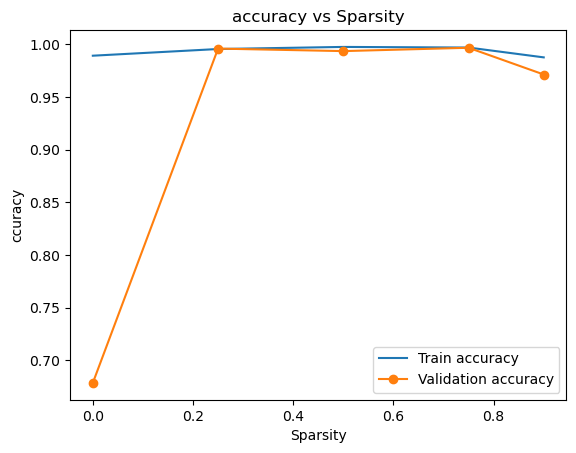

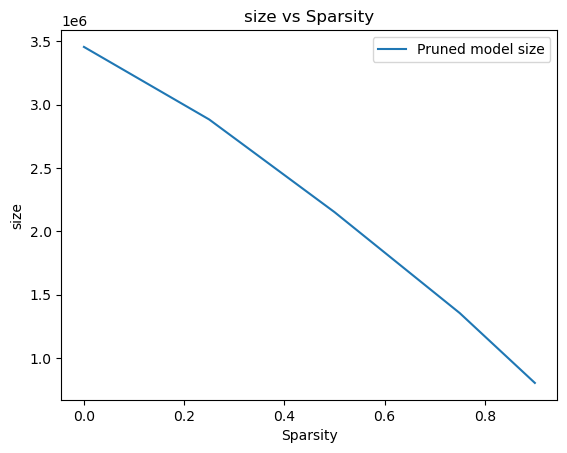

In [41]:
#Plot result !

sparsity_levels = [0, 0.25, 0.5, 0.75, 0.9]
#accuracy
plt.plot(sparsity_levels, train_accs, label='Train accuracy')
plt.plot(sparsity_levels, val_accs, marker='o', label='Validation accuracy')
plt.xlabel("Sparsity")
plt.ylabel("ccuracy")
plt.legend()
plt.title("accuracy vs Sparsity")
plt.show()

#size
plt.plot(sparsity_levels, model_sizes, label='Pruned model size')
plt.xlabel("Sparsity")
plt.ylabel("size")
plt.legend()
plt.title("size vs Sparsity")
plt.show()



Nous voulions choisir le meilleur compromis entre la taille du modèle et sa précision. Pour cela, nous avons pris comme critère la meilleure performance sur le jeu de validation. Selon ce critère, la valeur de sparsity 0.5 a été retenue.

Cependant, ce n’est probablement pas le choix le plus pertinent pour un déploiement sur une cible embarqué. En effet :

- Avec sparsity 0.75, la taille du modèle est quasiment divisée par deux, pour une baisse de précision très faible sur le jeu de validation.

- Avec sparsity 0.9, la taille du modèle est réduite d’environ trois fois, pour une diminution de précision d’à peine 1 % sur le jeu de validation.

Pour un modèle embarqué, 0.9 seraient probablement plus adaptées, car elles permet de réduire fortement la taille du modèle tout en conservant une performance presque équivalente.

 - **TODO: For the selected model, evaluate the performance on the final test set**

In [26]:
# TODO
best_pruned_model = setup_model("constant_pruning.h5")

best_pruned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

final_loss, final_accuracy = best_pruned_model.evaluate(xfinal, yfinal)

print("Final accuracy <3 :", final_accuracy)


62/62 [==============================] - 2s 35ms/step - loss: 0.1176 - accuracy: 0.9595
Final accuracy <3 : 0.9595494270324707


## 1.2 Quantization

Secondly, we will compress our CNN using quantization optimization as implemented in TensorFlow Lite.
The quantization is directly performed during the conversion of the TensorFlow model in a file .tflite.

This file can be used directly by a TensorFlow Lite interpreter on an embedded device (if small enough) !

## Given funtions
We give you a small set of functions that will help you during the following of the lab.
These functions mainly serve
- to write them to files (see the doc of each function),
- to evaluate the accuracy of the tensorflow lite model.

In [27]:
def save_tflite_model(model, model_file=None):
    """Save a TensorFlow Lite model to a file

    Parameters
    ----------
    model : tflite_model
        The tflite model to save.
    model_file : str (Optional)
        The file where the model should be saved
        
    Returns
    -------
    str
        The file where the model has been saved
    """
    if model_file is None:
        _, model_file = tempfile.mkstemp('.tflite')
    with open(model_file, 'wb') as f:
        f.write(model)

    return model_file

def tflite_evaluate(X, y, model=None, model_file=None):
    """Evaluate a TensorFlow Lite model
    
    Parameters
    ----------
    X, y : list, list
        The labeled dataset
    model : tf_model_lite (Optional)
        The model to evaluate
    model_file : str (Optional)
        The file where the model is saved
        
    Returns
    -------
    float
        The accuracy of the model on the dataset
    """
    if model is None and model_file is None:
        raise ValueError("tflite_evaluate: give either model or model_file")
    
    # Load and run the TensorFlow Lite model on test data
    if model is not None:
        interpreter = tf.lite.Interpreter(model_pcontent=model)
    else:
        interpreter = tf.lite.Interpreter(model_path=model_file)
    interpreter.allocate_tensors()

    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Evaluate the model
    prediction_digits = []
    for test_image in X:
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        interpreter.invoke()

        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
        
    tflite_qaware_accuracy = (np.array(prediction_digits) == np.argmax(y, axis=1)).mean()
    return tflite_qaware_accuracy

def convert_to_TFLite(model, optimizations=None):
    """Convert a model to TensorFlow Lite format with possible optimizations
    
    Parameters
    ----------
    model : tf_model
        The model to convert
    optimizations : list (Optional)
        The optimization options
        
    Returns
    -------
    tflite_model
        The converted model
    """
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    if optimizations is not None:
        converter.optimizations = optimizations
    quant_tflite_model = converter.convert()
    return quant_tflite_model

- Load the pruned model obtained before

In [28]:
# TODO

pruned_model = setup_model("constant_pruning.h5")

- **TODO: convert the model to the TensorFlow Lite format**
    - use *convert_to_TFLite* for the conversion: look inside this function and explain very briefly the steps it follows,
    - use *save_tflite_model* to save the obtained model to the file "pruning_quant.tflite".

In [29]:
# TODO

tflite_mod = convert_to_TFLite(pruned_model, [tf.lite.Optimize.DEFAULT] )

#save

tflite_file = save_tflite_model(tflite_mod, "pruning_quant.tflite")

INFO:tensorflow:Assets written to: /tmp/tmp64yoy6g8/assets


INFO:tensorflow:Assets written to: /tmp/tmp64yoy6g8/assets
2026-01-18 18:57:04.563339: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2026-01-18 18:57:04.563358: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2026-01-18 18:57:04.563579: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp64yoy6g8
2026-01-18 18:57:04.564771: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2026-01-18 18:57:04.564781: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp64yoy6g8
2026-01-18 18:57:04.567754: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2026-01-18 18:57:04.568530: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2026-01-18 18:57:04.595987: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

- **TODO: evaluate your results**: for the base model, the pruned model, and the tflite model
    - display the size of the model using *get_gzipped_model_size*. For the tflite model, input the *.tflite* directly with the parameter keras_file.
    - display the accuracy obtained on the final test set. For the tflite model:
        - use the function *tflite_evaluate* to get the accuracy,
        - look inside this function and explain very briefly the steps it follows.

In [30]:
# Load models
base_model = setup_model("best_CNN.keras")
pruned_model = setup_model("constant_pruning.h5")
pruned_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


_, _, base_size = get_gzipped_model_size(model=base_model)
_, _, pruned_size = get_gzipped_model_size(model=pruned_model)
_, _, tflite_size = get_gzipped_model_size(keras_file="pruning_quant.tflite")

print("Pour Base :", base_size)
print("Pour Pruned :", pruned_size)
print("Pour TFLite:", tflite_size)


base_loss, base_acc = base_model.evaluate(xfinal, yfinal)


pruned_loss, pruned_acc = pruned_model.evaluate(xfinal, yfinal)


tflite_acc = tflite_evaluate(xfinal, yfinal,model_file="pruning_quant.tflite")

print("Base accuracy:", base_acc)
print("Pruned accuracy:", pruned_acc)
print("TFLite model accuracy:", tflite_acc)


/home/tom/miniconda3/envs/5A_IA/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Pour Base : 3433838
Pour Pruned : 2162625
Pour TFLite: 547847
62/62 [==============================] - 2s 36ms/step - loss: 0.1176 - accuracy: 0.9595


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Base accuracy: 0.9703021049499512
Pruned accuracy: 0.9595494270324707
TFLite model accuracy: 0.9585253456221198


- **TODO: Questions**:
    - Are you satisfied with the results of the compression ?
    - Analyse in terms of accuracy, model size.
    - What possible benefits can you hope for embedding in a device ? Give at least 3.

Oui, les résultats sont globalement satisfaisants. La compression a permis de réduire fortement la taille du modèle tout en conservant une précision relativement élevée : 

- Modèle de base : 3 433 838 octets compressés, accuracy $\approx$  97.03 %

- Modèle pruné : 2 162 625 octets compressés, accuracy $\approx$ 95.95 %

- Modèle TFLite : 547 847 octets compressés, accuracy $\approx$  95.85 %

La perte de précision est modérée ($\approx$ 1–1,5 %) par rapport au modèle de base, alors que la taille du fichier compressé est réduite de manière très significative ($\approx$ 84% pour le modèle TFLite).

<ins>Analyse</ins> :

Précision : La compression entraîne une légère baisse d’accuracy, mais elle reste élevée.

Taille du modèle : La réduction est très importante ce qui est particulièrement utile pour un déplooiment sur un dispotitif embarqué

<ins> Bénéfices pour un usage embarqué : </ins>

Réduction mémoire : Le modèle TFLite est beaucoup plus léger sur disque particulièrement utile pour des cible embarqué qui possède souvent un stockage limité (même si de plus en plus élevé)

Économie d’énergie : Un modèle plus petit permet de faire moins de calculs et donc consomme moins de batterie.

Réduction : moins de calculs donc un CPU qui travaille moins utile pour un usage embarqué avec des équipement limité en puissance de calcul (même si de plus en plus élevé également)

# 3. **(Optionnal)** Development of a Fall Detection System (FDS) in production

In this part, we ask you to use the lectures, the labs, your own culture, and your imagination.

A few directions:
- You can answer to this part directly inside the jupyter-notebook or on a separate pdf file to send together with your notebook.
- The length should be around 2 pages of content
- We prefer 2 page with content that is synthetic, over 10 pages of gibberish.

Up to now:
- you have set up a classification model for Human Activity Recognition using data from sensors on the person's body (ankle, wrist, and chest).
- you have set up a compressed CNN model for embedded fall detection using images from a video camera.

### **Question to develop** : How would you build a fall detection system for old people’s homes ("maisons de retraite") ? Be creative !

Your answer should **include** answers to these aspects:
- Application itself
    - Does this problem correspond to an application of AI at the edge ? How so ?
    - BLERP analysis
- Method developped
    - Machine learning
        - Is it a supervised or unsupervised learning problem ?
        - Where does the training happen ?
        - What mechine learning approach do you consider ? What constraints should drive your choice ?
    - Getting and combining data
        - Do you need additional data for your application ?
        - Using sensor data and image data, how do you combine them ? Synchronisation/Ensemble learning ?
        - What happens if the elder is outside of the field of vision of the camera ?
    - What type of hardware would you use (no need to specific chip names, just the general type: CPU/GPU/TPU/Laptop/microcontrollers, security cameras/smartwatches/smartphones, etc.)
    - Give an idea of the steps you would follow to develop the whole fall detection system
- Final validation and production
    - Which validation method will you use ?
    - Where do you embed and run the final model ?
    - Once your model is deployed, will you need to update it ? When/How ?